# 5-1、数据管道Dataset
如果需要训练的数据大小不大，例如不到1G，那么可以直接全部读入内存中进行训练，这样一般效率最高。

但如果需要训练的数据很大，例如超过10G，无法一次载入内存，那么通常需要在训练的过程中分批逐渐读入。

使用 tf.data API 可以构建数据输入管道，轻松处理大量的数据，不同的数据格式，以及不同的数据转换。

## 一、构建数据管道
可以从 Numpy array, Pandas DataFrame, Python generator, csv文件, 文本文件, 文件路径, tfrecords文件等方式构建数据管道。

其中通过Numpy array, Pandas DataFrame, 文件路径构建数据管道是最常用的方法。

通过tfrecords文件方式构建数据管道较为复杂，需要对样本构建tf.Example后压缩成字符串写到tfrecords文件，读取后再解析成tf.Example。

但tfrecords文件的优点是压缩后文件较小，便于网络传播，加载速度较快。

### 1、从numpy array构建数据管道

In [3]:
import tensorflow as tf
import numpy as np
from sklearn import datasets
iris = datasets.load_iris()

ds1 = tf.data.Dataset.from_tensor_slices((iris["data"],iris["target"]))
for feature,label in ds1.take(5):
    print(feature,label)

tf.Tensor([5.1 3.5 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.9 3.  1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.7 3.2 1.3 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([4.6 3.1 1.5 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor([5.  3.6 1.4 0.2], shape=(4,), dtype=float64) tf.Tensor(0, shape=(), dtype=int64)


### 2、从Pandas DataFrame构建数据管道

In [4]:
import tensorflow as tf
from sklearn import datasets
import pandas as pd

iris = datasets.load_iris()
dfiris = pd.DataFrame(iris["data"],columns=iris.feature_names)

ds2 = tf.data.Dataset.from_tensor_slices((dfiris.to_dict("list"),iris["target"]))
for feature ,label in ds2.take(3):
    print(feature,label)

{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=5.1>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.5>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.9>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.0>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.4>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)
{'sepal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=4.7>, 'sepal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=3.2>, 'petal length (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=1.3>, 'petal width (cm)': <tf.Tensor: shape=(), dtype=float32, numpy=0.2>} tf.Tensor(0, shape=(), dtype=int64)


### 3、从Python generator构建数据管道

In [2]:
import tensorflow as tf
from matplotlib import pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_generator = ImageDataGenerator(rescale = 1.0/255).flow_from_directory(
                    "./data/cifar2/test/",
                    target_size = (32,32),
                    batch_size = 20,
                    class_mode='binary')
classdict = image_generator.class_indices
print(classdict)
def generator():
    for features,label in image_generator:
        yield(features,label)
ds3 = tf.data.Dataset.from_generator(generator,output_types=(tf.float32,tf.int32))

Found 2000 images belonging to 2 classes.
{'airplane': 0, 'automobile': 1}


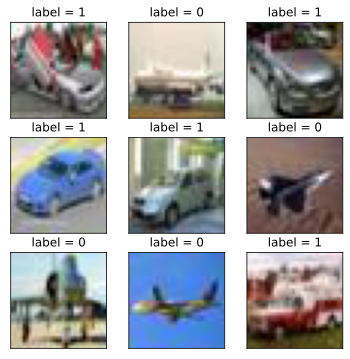

In [3]:
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.figure(figsize=(6,6)) 
for i,(img,label) in enumerate(ds3.unbatch().take(9)):
    ax=plt.subplot(3,3,i+1)
    ax.imshow(img.numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([]) 
plt.show()

### 4、从csv文件构建数据管道

In [6]:
ds4 = tf.data.experimental.make_csv_dataset(file_pattern = ["./data/titanic/train.csv","./data/titanic/test.csv"],
                                           batch_size = 3,
                                           label_name = "Survived",
                                           na_value = "",
                                           num_epochs=1,
                                           ignore_errors=True)
for data,label in ds4.take(2):
    print(data,label)

OrderedDict([('PassengerId', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([794, 364, 738], dtype=int32)>), ('Pclass', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([1, 3, 1], dtype=int32)>), ('Name', <tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'Hoyt, Mr. William Fisher', b'Asim, Mr. Adola',
       b'Lesurer, Mr. Gustave J'], dtype=object)>), ('Sex', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'male', b'male', b'male'], dtype=object)>), ('Age', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 0., 35., 35.], dtype=float32)>), ('SibSp', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>), ('Parch', <tf.Tensor: shape=(3,), dtype=int32, numpy=array([0, 0, 0], dtype=int32)>), ('Ticket', <tf.Tensor: shape=(3,), dtype=string, numpy=array([b'PC 17600', b'SOTON/O.Q. 3101310', b'PC 17755'], dtype=object)>), ('Fare', <tf.Tensor: shape=(3,), dtype=float32, numpy=array([ 30.6958,   7.05  , 512.3292], dtype=float32)>), ('Cabin', <tf.Tensor: shape=(3,

### 5、从tfrecords文件构建数据管道

In [8]:
import os
import numpy as np


#将cifar的test部分写成tfrecords
def create_tfrecords(inpath,outpath):
    writer = tf.io.TFRecordWriter(outpath)
    dirs = os.listdir(inpath)
    for index,name in enumerate(dirs):
        class_path = inpath+"/"+name+"/"
        for img_name in os.listdir(class_path):
            img_path = class_path + img_name
            img = tf.io.read_file(img_path)
            example = tf.train.Example(
            features = tf.train.Features(feature={
                'label':tf.train.Feature(int64_list = tf.train.Int64List(value = [index])),
                'img_raw':tf.train.Feature(bytes_list = tf.train.BytesList(value= [img.numpy()]))
            }))
            writer.write(example.SerializePartialToString())
    writer.close()
    
create_tfrecords("./data/cifar2/test/","./data/cifar2_test.tfrecords")

In [9]:
from matplotlib import pyplot as plt

def parse_example(proto):
    description = {
        'img_raw':tf.io.FixedLenFeature([],tf.string),
        'label':tf.io.FixedLenFeature([],tf.int64)
    }
    example = tf.io.parse_single_example(proto,description)
    img = tf.image.decode_jpeg(example["img_raw"])
    img = tf.image.resize(img,(32,32))
    label = example['label']
    return (img,label)

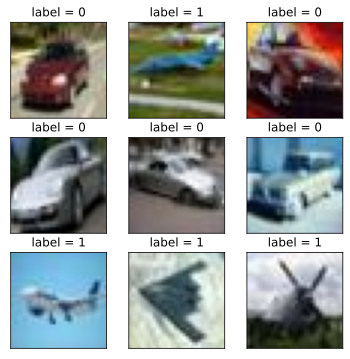

In [10]:
ds7 = tf.data.TFRecordDataset("./data/cifar2_test.tfrecords").map(parse_example).shuffle(3000)

%matplotlib inline
%config InlineBackend.figure_format='svg'
plt.figure(figsize=(6,6))
for i,(img,label) in enumerate(ds7.take(9)):
    ax = plt.subplot(3,3,i+1)
    ax.imshow((img/255.0).numpy())
    ax.set_title("label = %d"%label)
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

## 二、应用数据转换

Dataset数据结构应用非常灵活，因为她本质上是一个Sequence序列，其每个元素可以是各种类型，例如可以是张量，列表，字典，也可以是Dataset。

Dataset包含了非常丰富的数据转换功能。
- map：将转换函数映射到数据集的每一个元素

- flat_map：将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平

- interleave：效果类似flat_map，但可以将不同来源的数据夹在一起

- filter：过滤掉某些元素

- zip: 将两个长度相同的Dataset横向铰合。

- concatenate: 将两个Dataset纵向连接。

- reduce: 执行归并操作。

- batch : 构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。

- padded_batch: 构建批次，类似batch, 但可以填充到相同的形状。

- window :构建滑动窗口，返回Dataset of Dataset.

- shuffle: 数据顺序洗牌。

- repeat: 重复数据若干次，不带参数时，重复无数次。

- shard: 采样，从某个位置开始隔固定距离采样一个元素。

- take: 采样，从开始位置取前几个元素。

In [25]:
#map:将转换函数映射到数据集每一个元素

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_map = ds.map(lambda x:tf.strings.split(x," "))
for x in ds_map:
    print(x)

tf.Tensor([b'hello' b'world'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'China'], shape=(2,), dtype=string)
tf.Tensor([b'hello' b'Beijing'], shape=(2,), dtype=string)


In [26]:
#flat_map:将转换函数映射到数据集的每一个元素，并将嵌套的Dataset压平。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_flatmap = ds.flat_map(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_flatmap:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [27]:
# interleave: 效果类似flat_map,但可以将不同来源的数据夹在一起。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
ds_interleave = ds.interleave(lambda x:tf.data.Dataset.from_tensor_slices(tf.strings.split(x," ")))
for x in ds_interleave:
    print(x)

tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'hello', shape=(), dtype=string)
tf.Tensor(b'world', shape=(), dtype=string)
tf.Tensor(b'China', shape=(), dtype=string)
tf.Tensor(b'Beijing', shape=(), dtype=string)


In [30]:
#filter:过滤掉某些元素。

ds = tf.data.Dataset.from_tensor_slices(["hello world","hello China","hello Beijing"])
#找出含有字母a或B的元素
ds_filter = ds.filter(lambda x: tf.strings.regex_full_match(x, ".*[a|B].*"))
for x in ds_filter:
    print(x)
    

tf.Tensor(b'hello China', shape=(), dtype=string)
tf.Tensor(b'hello Beijing', shape=(), dtype=string)


In [32]:
#zip:将两个长度相同的Dataset横向铰合。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds3 = tf.data.Dataset.range(6,9)
ds_zip = tf.data.Dataset.zip((ds1,ds2,ds3))
for x,y,z in ds_zip:
    print(x.numpy(),y.numpy(),z.numpy())

0 3 6
1 4 7
2 5 8


In [33]:
#condatenate:将两个Dataset纵向连接。

ds1 = tf.data.Dataset.range(0,3)
ds2 = tf.data.Dataset.range(3,6)
ds_concat = tf.data.Dataset.concatenate(ds1,ds2)
for x in ds_concat:
    print(x)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)


In [34]:
#reduce:执行归并操作。

ds = tf.data.Dataset.from_tensor_slices([1,2,3,4,5.0])
result = ds.reduce(0.0,lambda x,y:tf.add(x,y))
result

<tf.Tensor: shape=(), dtype=float32, numpy=15.0>

In [35]:
#batch:构建批次，每次放一个批次。比原始数据增加一个维度。 其逆操作为unbatch。 

ds = tf.data.Dataset.range(12)
ds_batch = ds.batch(4)
for x in ds_batch:
    print(x)

tf.Tensor([0 1 2 3], shape=(4,), dtype=int64)
tf.Tensor([4 5 6 7], shape=(4,), dtype=int64)
tf.Tensor([ 8  9 10 11], shape=(4,), dtype=int64)


In [36]:
#padded_batch:构建批次，类似batch, 但可以填充到相同的形状。

elements = [[1, 2],[3, 4, 5],[6, 7],[8]]
ds = tf.data.Dataset.from_generator(lambda: iter(elements), tf.int32)

ds_padded_batch = ds.padded_batch(2,padded_shapes = [4,])
for x in ds_padded_batch:
    print(x)   

tf.Tensor(
[[1 2 0 0]
 [3 4 5 0]], shape=(2, 4), dtype=int32)
tf.Tensor(
[[6 7 0 0]
 [8 0 0 0]], shape=(2, 4), dtype=int32)


In [37]:
#window:构建滑动窗口，返回Dataset of Dataset.

ds = tf.data.Dataset.range(12)
#window返回的是Dataset of Dataset,可以用flat_map压平
ds_window = ds.window(3, shift=1).flat_map(lambda x: x.batch(3,drop_remainder=True)) 
for x in ds_window:
    print(x)

tf.Tensor([0 1 2], shape=(3,), dtype=int64)
tf.Tensor([1 2 3], shape=(3,), dtype=int64)
tf.Tensor([2 3 4], shape=(3,), dtype=int64)
tf.Tensor([3 4 5], shape=(3,), dtype=int64)
tf.Tensor([4 5 6], shape=(3,), dtype=int64)
tf.Tensor([5 6 7], shape=(3,), dtype=int64)
tf.Tensor([6 7 8], shape=(3,), dtype=int64)
tf.Tensor([7 8 9], shape=(3,), dtype=int64)
tf.Tensor([ 8  9 10], shape=(3,), dtype=int64)
tf.Tensor([ 9 10 11], shape=(3,), dtype=int64)


## 三、提升管道性能
训练深度学习模型常常会非常耗时。

模型训练的耗时主要来自于两个部分，一部分来自数据准备，另一部分来自参数迭代。

参数迭代过程的耗时通常依赖于GPU来提升。

而数据准备过程的耗时则可以通过构建高效的数据管道进行提升。

以下是一些构建高效数据管道的建议。

1、使用 prefetch 方法让数据准备和参数迭代两个过程相互并行。

2、使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。

3、使用 map 时设置num_parallel_calls 让数据转换过程多进程执行。

4、使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。

5、使用 map转换时，先batch, 然后采用向量化的转换方法对每个batch进行转换。

### 1、使用prefetch的方法让数据准备和参数迭代两个过程相互并行

In [12]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    ts = tf.timestamp()
    today_ts = ts%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8,end = "")
    tf.print(timestring)

In [14]:
#串行的方式进行

import time
#模拟数据准备
def generator():
    for i in range(10):
        time.sleep(2)
        yield i
ds = tf.data.Dataset.from_generator(generator,output_types=(tf.int32))

#模拟参数迭代
def train_step():
    #假设每步训练需要1s
    time.sleep(1)

printbar()
tf.print(tf.constant("start training..."))
for x in ds:
    train_step()
printbar()
tf.print(tf.constant("end training..."))

================================================================================11:38:48
start training...
================================================================================11:39:18
end training...


In [15]:
#并行的方式进行
# 训练过程预计耗时 max(10*2,10*1) = 20s
printbar()
tf.print(tf.constant("start training with prefetch..."))

# tf.data.experimental.AUTOTUNE 可以让程序自动选择合适的参数
for x in ds.prefetch(buffer_size = tf.data.experimental.AUTOTUNE):
    train_step()  
    
printbar()
tf.print(tf.constant("end training..."))

================================================================================11:40:14
start training with prefetch...
================================================================================11:40:35
end training...


### 2、使用 interleave 方法可以让数据读取过程多进程执行,并将不同来源数据夹在一起。

In [16]:
ds_files = tf.data.Dataset.list_files("./data/titanic/*.csv")
ds = ds_files.flat_map(lambda x:tf.data.TextLineDataset(x).skip(1))
for line in ds.take(4):
    print(line)

tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,,S', shape=(), dtype=string)
tf.Tensor(b'635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,,S', shape=(), dtype=string)
tf.Tensor(b'701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C', shape=(), dtype=string)


In [17]:
ds_files = tf.data.Dataset.list_files("./data/titanic/*.csv")
ds = ds_files.interleave(lambda x:tf.data.TextLineDataset(x).skip(1))
for line in ds.take(8):
    print(line)

tf.Tensor(b'181,0,3,"Sage, Miss. Constance Gladys",female,,8,2,CA. 2343,69.55,,S', shape=(), dtype=string)
tf.Tensor(b'493,0,1,"Molson, Mr. Harry Markland",male,55.0,0,0,113787,30.5,C30,S', shape=(), dtype=string)
tf.Tensor(b'405,0,3,"Oreskovic, Miss. Marija",female,20.0,0,0,315096,8.6625,,S', shape=(), dtype=string)
tf.Tensor(b'53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.0,1,0,PC 17572,76.7292,D33,C', shape=(), dtype=string)
tf.Tensor(b'635,0,3,"Skoog, Miss. Mabel",female,9.0,3,2,347088,27.9,,S', shape=(), dtype=string)
tf.Tensor(b'388,1,2,"Buss, Miss. Kate",female,36.0,0,0,27849,13.0,,S', shape=(), dtype=string)
tf.Tensor(b'701,1,1,"Astor, Mrs. John Jacob (Madeleine Talmadge Force)",female,18.0,1,0,PC 17757,227.525,C62 C64,C', shape=(), dtype=string)
tf.Tensor(b'192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0,,S', shape=(), dtype=string)


### 3、使用 map 时设置num_parallel_calls 让数据转换过程多进行执行。

In [18]:
ds = tf.data.Dataset.list_files("./data/cifar2/train/*/*.jpg")
def load_image(img_path,size=(32,32)):
    label = 1 if tf.strings.regex_full_match(img_path,".*/automobile/.*") else 0
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img)
    img = tf.image.resize(img,size)
    return (img,label)

In [19]:
#单进程转换
printbar()
tf.print(tf.constant("start transformation..."))

ds_map = ds.map(load_image)
for _ in ds_map:
    pass

printbar()
tf.print(tf.constant("end transformation..."))

================================================================================11:59:39
start transformation...
================================================================================11:59:53
end transformation...


In [20]:
#多进程转换
printbar()
tf.print(tf.constant("start parallel transformation..."))

ds_map_parallel = ds.map(load_image,num_parallel_calls = tf.data.experimental.AUTOTUNE)
for _ in ds_map_parallel:
    pass

printbar()
tf.print(tf.constant("end parallel transformation..."))

================================================================================11:59:53
start parallel transformation...
================================================================================11:59:54
end parallel transformation...


### 4、使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。

In [21]:
import time

# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32))

# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    pass

# 训练过程预计耗时 (5*2+5*0)*3 = 30s
printbar()
tf.print(tf.constant("start training..."))
for epoch in tf.range(3):
    for x in ds:
        train_step()  
    printbar()
    tf.print("epoch =",epoch," ended")
printbar()
tf.print(tf.constant("end training..."))

================================================================================12:00:52
start training...
================================================================================12:01:02
epoch = 0  ended
================================================================================12:01:12
epoch = 1  ended
================================================================================12:01:22
epoch = 2  ended
================================================================================12:01:22
end training...


In [22]:
import time

# 模拟数据准备
def generator():
    for i in range(5):
        #假设每次准备数据需要2s
        time.sleep(2) 
        yield i 

# 使用 cache 方法让数据在第一个epoch后缓存到内存中，仅限于数据集不大情形。
ds = tf.data.Dataset.from_generator(generator,output_types = (tf.int32)).cache()

# 模拟参数迭代
def train_step():
    #假设每一步训练需要0s
    time.sleep(0) 

# 训练过程预计耗时 (5*2+5*0)+(5*0+5*0)*2 = 10s
printbar()
tf.print(tf.constant("start training..."))
for epoch in tf.range(3):
    for x in ds:
        train_step()  
    printbar()
    tf.print("epoch =",epoch," ended")
printbar()
tf.print(tf.constant("end training..."))

================================================================================12:01:22
start training...
================================================================================12:01:32
epoch = 0  ended
================================================================================12:01:32
epoch = 1  ended
================================================================================12:01:32
epoch = 2  ended
================================================================================12:01:32
end training...


### 5、使用 map转换时，先batch, 然后采用向量化的转换方法对每个batch进行转换。

In [23]:
#先map后batch
ds = tf.data.Dataset.range(100000)
ds_map_batch = ds.map(lambda x:x**2).batch(20)

printbar()
tf.print(tf.constant("start scalar transformation..."))
for x in ds_map_batch:
    pass
printbar()
tf.print(tf.constant("end scalar transformation..."))

================================================================================12:01:48
start scalar transformation...
================================================================================12:01:59
end scalar transformation...


In [24]:
#先batch后map
ds = tf.data.Dataset.range(100000)
ds_batch_map = ds.batch(20).map(lambda x:x**2)

printbar()
tf.print(tf.constant("start vector transformation..."))
for x in ds_batch_map:
    pass
printbar()
tf.print(tf.constant("end vector transformation..."))

================================================================================12:02:03
start vector transformation...
================================================================================12:02:05
end vector transformation...
